In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings('ignore')

C:\Users\micsa\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Training Data
season_stats = pd.read_csv('Seasons_Stats.csv')
season_stats = season_stats.drop(['blanl', 'blank2', 'Unnamed: 0'], axis=1)
season_stats = season_stats[season_stats.Tm.str.contains('TOT') == False]
season_stats['MVP_Candidate'] = np.where(season_stats['MVPSHARES'] > 0, 'Yes', 'No')
season_stats['Player'] = season_stats['Player'].astype(str).str.replace('*', '')
season_stats['PPG'] = season_stats['PTS'] / season_stats['G']
season_stats['ASTPG'] = season_stats['AST'] / season_stats['G']
season_stats['STLPG'] = season_stats['STL'] / season_stats['G']
season_stats['BLKPG'] = season_stats['BLK'] / season_stats['G']
season_stats['PFPG'] = season_stats['PF'] / season_stats['G']
season_stats['TRPG'] = season_stats['TRB'] / season_stats['G']
season_stats['ORPG'] = season_stats['ORB'] / season_stats['G']
season_stats['DRPG'] = season_stats['DRB'] / season_stats['G']
season_stats['MPPG'] = season_stats['MP'] / season_stats['G']
season_stats['TOVPG'] = season_stats['TOV'] / season_stats['G']
season_stats = season_stats[season_stats['G'] >= 41.0]
season_stats = season_stats[season_stats['MPPG'] >= 25.0]
season_stats['Year'] = season_stats['Year'].astype(int)
season_stats = season_stats.dropna()

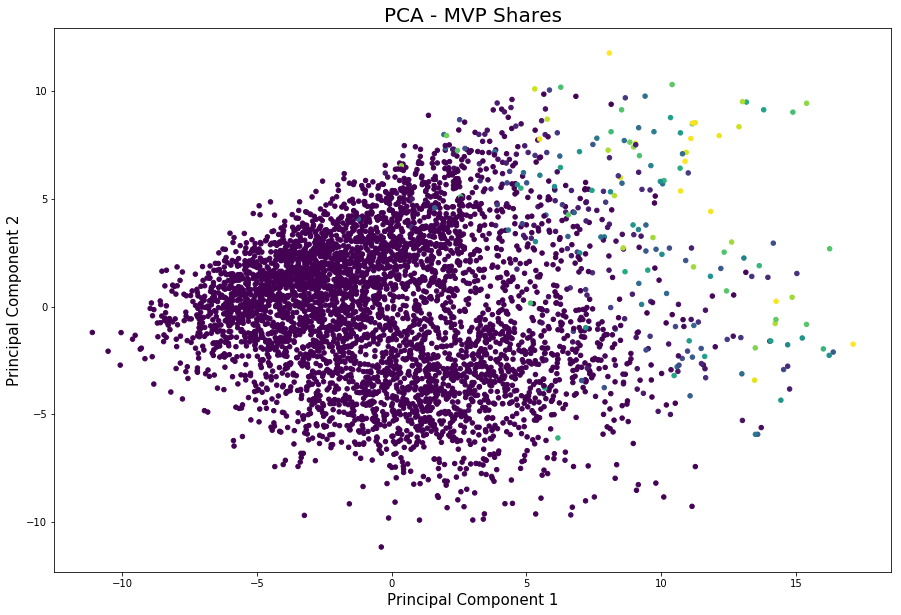

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pca_features = season_stats.drop(['Tm', 'Pos', 'Decade', 'MVP', 'MVP_Candidate',
                                 'MVPSHARES', 'Player'], axis=1)
x = pca_features
y = season_stats.loc[:, ['MVPSHARES']].values

x = StandardScaler().fit_transform(x)

pca = PCA(n_components=2)
principalcomponents = pca.fit_transform(x)
principalDF = pd.DataFrame(data = principalcomponents, columns = ['pc1', 'pc2'] )
principalDF = principalDF.reset_index(drop=True)

mvp_share = season_stats[['MVPSHARES']]
mvp_share = mvp_share.reset_index(drop=True)
finalDF = pd.concat([principalDF, mvp_share], axis=1)

fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)
ax.scatter(x = finalDF.pc1, y = finalDF.pc2, 
        c = finalDF['MVPSHARES'], s=20)
plt.title('PCA - MVP Shares', size = 20)
plt.xlabel('Principal Component 1', size=15)
plt.ylabel('Principal Component 2', size=15)
plt.show()

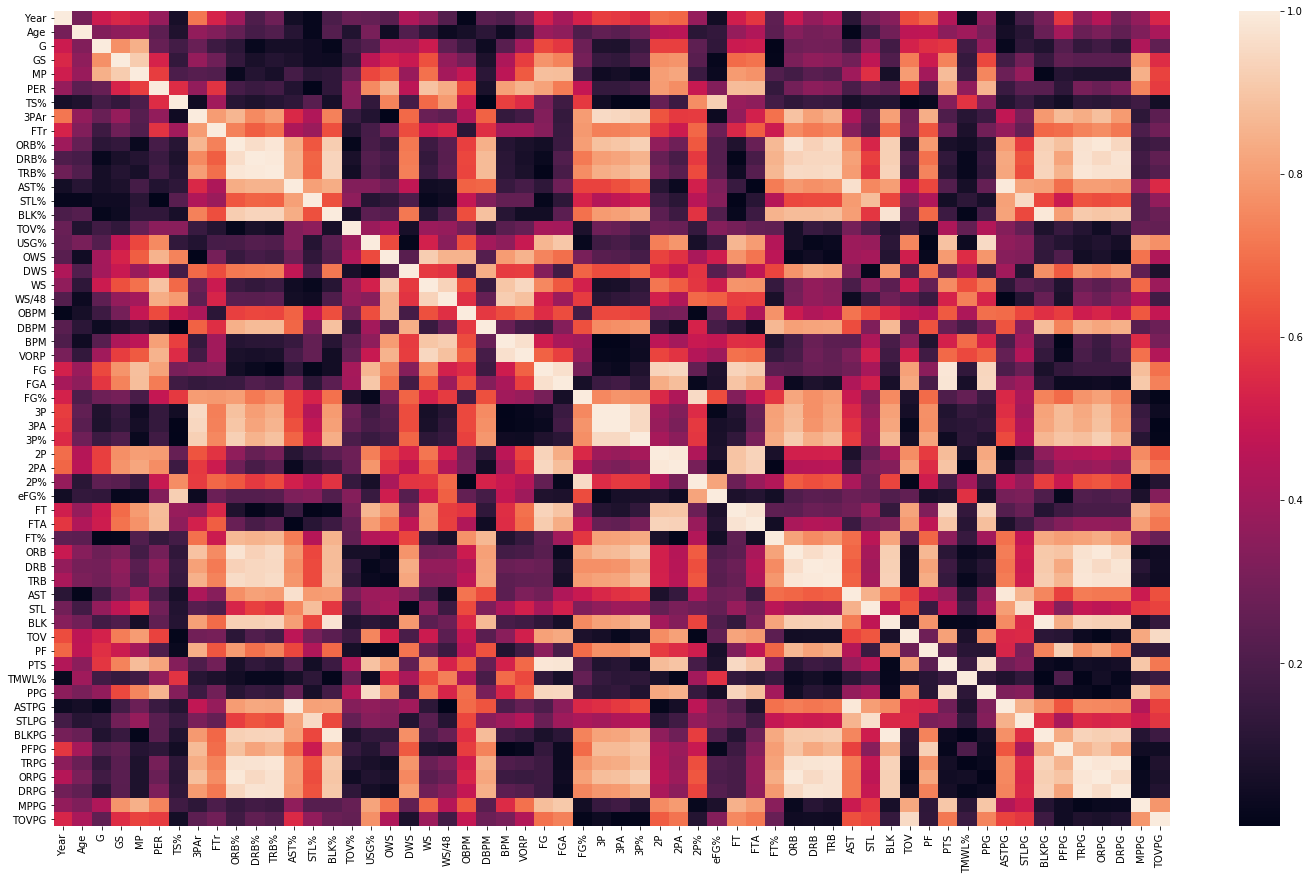

In [4]:
corr = season_stats.drop(['MVPSHARES', 'MVP_Candidate', 
                       'MVP', 'Tm', 'Player', 'Decade', 'Pos'], axis=1).corr()

corrmap = corr.corr().abs()
fig, ax = plt.subplots(figsize=(25, 15))
ax = sns.heatmap(corrmap)

In [6]:
# Run the model with all features to get feature importance
from sklearn.model_selection import train_test_split

y = season_stats['MVPSHARES']
X = season_stats.drop(['MVPSHARES', 'MVP_Candidate', 
                       'MVP', 'Tm', 'Player', 'Decade', 'Pos'], axis=1)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf.fit(X_train, y_train)

importance = pd.DataFrame()
importance['features'] = X_train.columns
importance['scores'] = rf.feature_importances_

importance.sort_values('scores', ascending=False).head(10)

,features,scores
19,WS,0.339962
5,PER,0.132232
47,TMWL%,0.109406
20,WS/48,0.034465
26,FGA,0.026713
16,USG%,0.024374
18,DWS,0.019900
32,2PA,0.018644
24,VORP,0.017622
25,FG,0.015425


In [7]:
from sklearn.ensemble import GradientBoostingRegressor

y = season_stats['MVPSHARES']
X = season_stats.drop(['MVPSHARES', 'MVP_Candidate', 
                       'MVP', 'Tm', 'Player', 'Decade', 'Pos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)

importance = pd.DataFrame()
importance['features'] = X_train.columns
importance['scores'] = gbr.feature_importances_

importance.sort_values('scores', ascending=False).head(10)

,features,scores
47,TMWL%,0.110959
19,WS,0.070117
5,PER,0.054462
20,WS/48,0.047387
18,DWS,0.043838
57,TOVPG,0.039905
24,VORP,0.037403
56,MPPG,0.033021
22,DBPM,0.031185
52,PFPG,0.030889


In [8]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

df = season_stats.drop(['MVPSHARES', 'MVP_Candidate', 
                       'MVP', 'Tm', 'Player', 'Decade', 'Pos'], axis=1)
X = add_constant(df)
var = pd.Series([variance_inflation_factor(X.values, i)
         for i in range (X.shape[1])],
          index=X.columns)

var = pd.DataFrame(var, columns = ['vif_score'])
var.sort_values('vif_score', ascending=False)

,vif_score
3P,inf
FG,inf
DRPG,inf
ORPG,inf
TRPG,inf
PTS,inf
TRB,inf
DRB,inf
ORB,inf
FT,inf


In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant

feat_todrop = ['FG', 'FGA', '3P','3PA', '2P', '2PA', 'Tm', 'Pos', 'Player', 'Decade',
               'MVPSHARES', 'MVP_Candidate', 'MVP', 'ORPG', 'OWS', 'TRB%', 'BPM', 'TRPG', 'FG%', 'MP', 'TOV',
              'FT', 'FTA', 'WS/48', 'ASTPG', 'BLKPG', 'PPG', 'STLPG', 'DRPG', 'PF',
              'TRB', 'PTS', 'STL', 'TOVPG', 'AST%', 'BLK%', '2P%', 'DWS', 'G', 'GS', 'Age', 'Year', 'ORB%', 'DRB%']
feat_to_use = ['WS', 'PER', 'TMWL%', 'PPG', 'BPM']
               
df = season_stats[feat_to_use]
X = add_constant(df)
vif = pd.Series([variance_inflation_factor(X.values, i)
         for i in range (X.shape[1])],
          index=X.columns)
vif = pd.DataFrame(vif, columns = ['vif_score'])
vif.sort_values('vif_score', ascending=False)

,vif_score
const,67.216576
PER,5.833101
WS,5.214202
BPM,3.930752
PPG,2.934180
TMWL%,1.645705


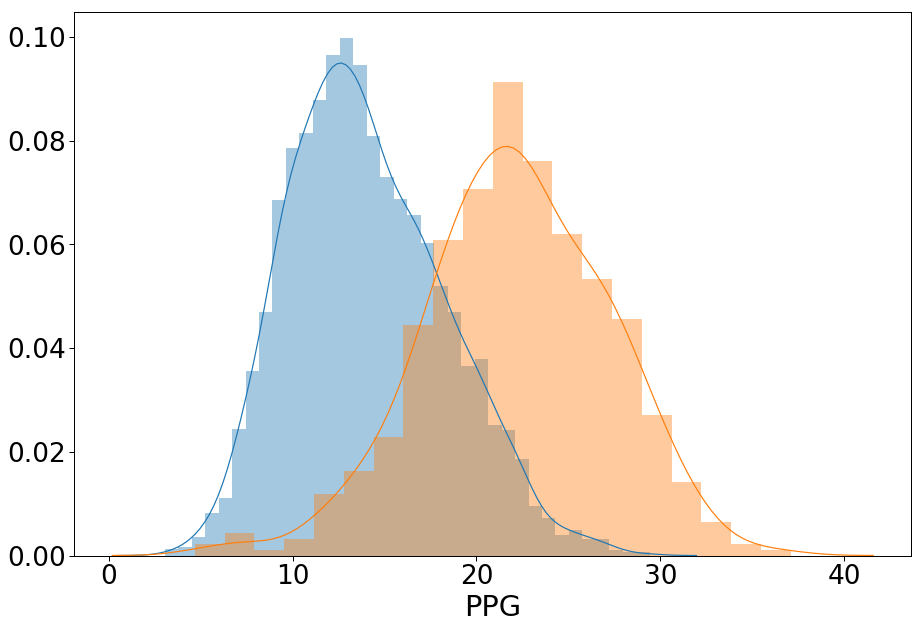

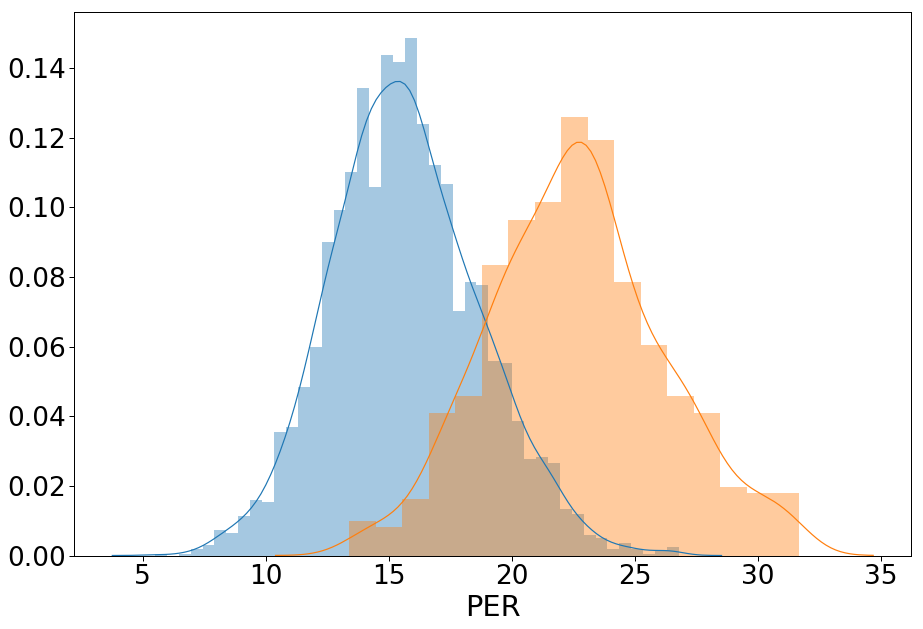

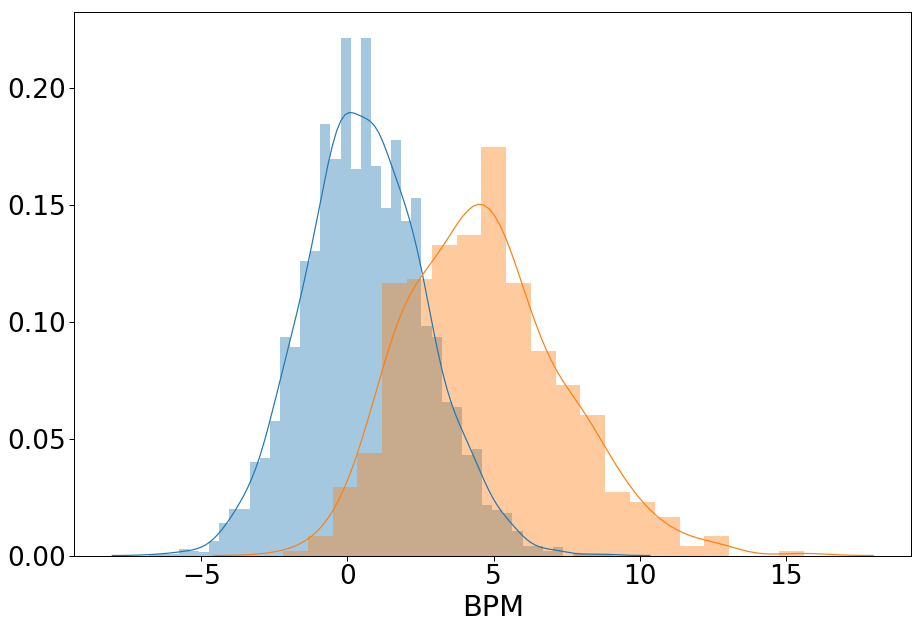

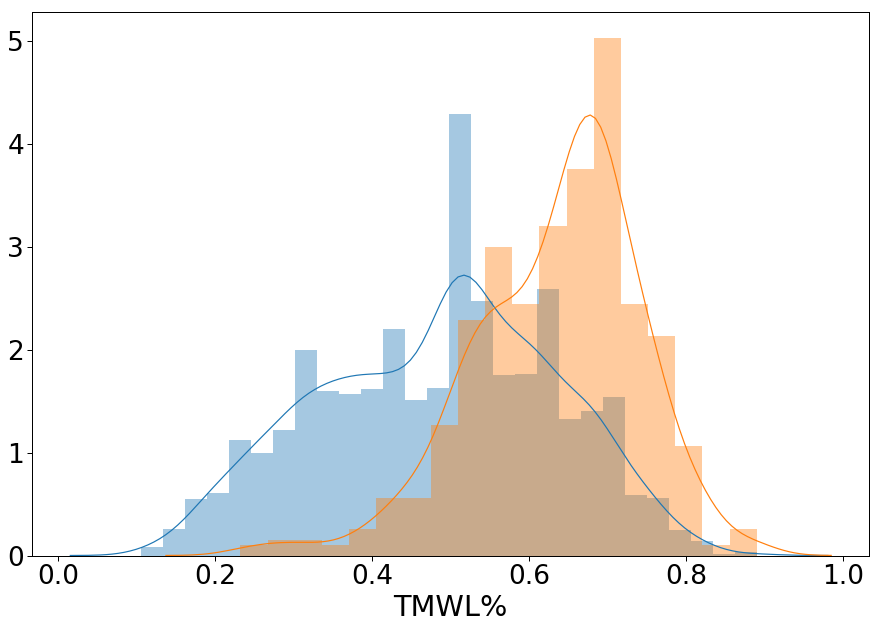

In [23]:
mvps = season_stats[season_stats['MVPSHARES'] > 0]
not_mvps = season_stats[season_stats['MVPSHARES'] == 0]
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_mvps['PPG'], ax=ax)
sns.distplot(mvps['PPG'], ax=ax)

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_mvps['PER'])
sns.distplot(mvps['PER'])

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_mvps['BPM'])
sns.distplot(mvps['BPM'])

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=2)
sns.distplot(not_mvps['TMWL%'])
sns.distplot(mvps['TMWL%'])

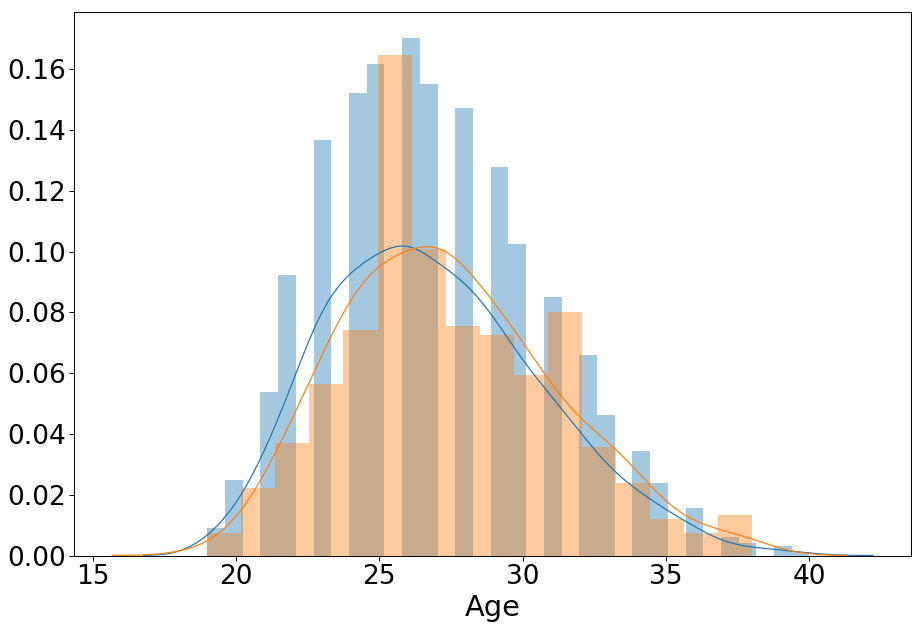

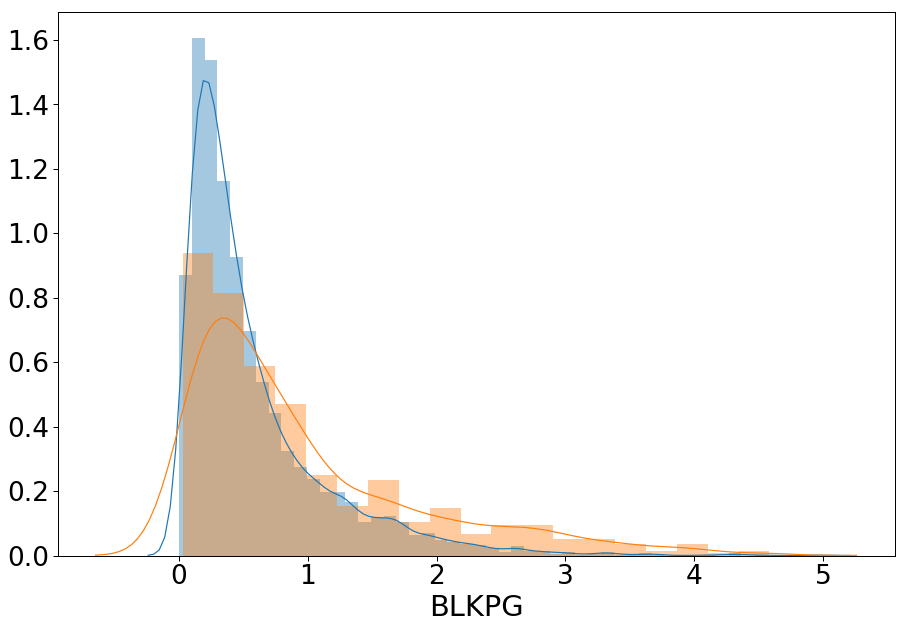

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_mvps['Age'])
sns.distplot(mvps['Age'])

fig, ax = plt.subplots(figsize=(15, 10))
sns.set_context("paper", font_scale=3)
sns.distplot(not_mvps['BLKPG'], ax=ax)
sns.distplot(mvps['BLKPG'], ax=ax)

Coefficients: 
 [0.00697586 0.00320655 0.02126317 0.00204985 0.00243458]
Intercept: 
 -0.12013819346580076
Score: 
 0.28615695571299826


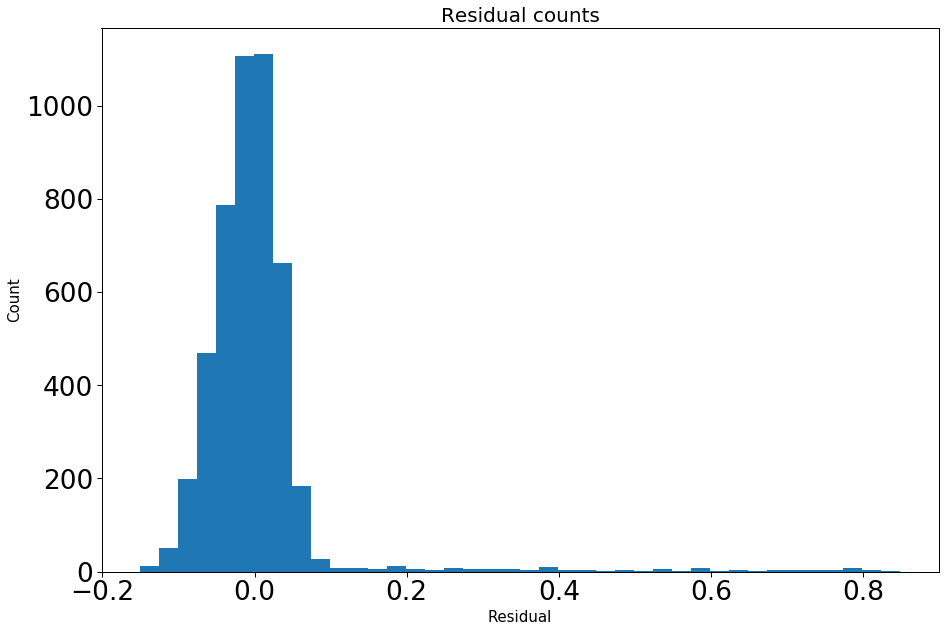

In [29]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split

y = season_stats['MVPSHARES']
X = df

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)
print('Coefficients: \n', regr.coef_)
print('Intercept: \n', regr.intercept_)
print('Score: \n', regr.score(X_test, y_test))

predicted = regr.predict(X).ravel()
actual = season_stats['MVPSHARES']

residual = actual - predicted

fig = plt.figure(figsize=(15,10))
plt.hist(residual, bins=40)
plt.title('Residual counts', size = 20)
plt.xlabel('Residual', size = 15)
plt.ylabel('Count', size = 15)
plt.show()

In [32]:
rf = RandomForestRegressor(random_state = 42)
rf.fit(X_train, y_train)
print(cross_val_score(rf, X_test, y_test, cv=5))
print(rf.score(X_test,y_test))

[0.61985556 0.71479713 0.65134053 0.7184713  0.755285  ]
0.7333411178565251


In [33]:
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [34]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Max number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num= 11)]
max_depth.append(None)

# Minimum number of samples required at each leaf node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators, 
              'max_features': max_features,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [35]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()

# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                              n_iter = 100, cv = 3, verbose=2, random_state=42,
                              n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.0min finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=100, n_jobs=-1,
          param_distributions={'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [84]:
rf_random.best_params_

{'n_estimators': 2000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [37]:
best_random = rf_random.best_estimator_
print(cross_val_score(best_random, X_test, y_test, cv=5))
print(best_random.score(X_test,y_test))

[0.62580453 0.77209976 0.63334405 0.69232583 0.75373083]
0.768777900264362


In [39]:
from sklearn.model_selection import GridSearchCV

# Create the parameter grid based on the results of random search
param_grid = {
    'bootstrap': [True],
    'max_depth': [50, 60, 70, 80],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [2, 4, 6],
    'n_estimators': [100, 200, 300, 1000, 2000]
}

rf = RandomForestRegressor()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed: 11.7min finished


{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [49]:
best_grid = grid_search.best_estimator_
best_grid

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [50]:
print(cross_val_score(best_grid, X_test, y_test, cv=5))
print(best_grid.score(X_test,y_test))

[0.64270097 0.78256458 0.66808315 0.69616926 0.77217246]
0.7652020322446957


In [67]:
# Grid with only the number of trees changed
tree_grid = {'n_estimators': [int(x) for x in np.linspace(1, 1000, 30)]}

# Create the grid search model and fit to the training data
tree_grid_search = GridSearchCV(rf, param_grid=tree_grid, verbose = 2, n_jobs=-1, cv = 3,
                                scoring = 'r2')
tree_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   43.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 35, 69, 104, 138, 173, 207, 242, 276, 311, 345, 379, 414, 448, 483, 517, 552, 586, 621, 655, 689, 724, 758, 793, 827, 862, 896, 931, 965, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

In [68]:
tree_grid_search.cv_results_

{'mean_fit_time': array([3.33317121e-03, 9.19002692e-02, 2.64892101e-01, 4.61316029e-01,
        6.21539752e-01, 7.77354399e-01, 9.42154328e-01, 1.10461569e+00,
        1.25278743e+00, 1.45686992e+00, 1.59283980e+00, 1.73425730e+00,
        1.87222997e+00, 2.37483517e+00, 2.99945362e+00, 3.60299230e+00,
        3.83567039e+00, 4.24991282e+00, 4.42994046e+00, 4.59122324e+00,
        4.85086449e+00, 5.01142693e+00, 5.06642660e+00, 5.39518714e+00,
        5.55855624e+00, 5.85558955e+00, 6.14227136e+00, 6.17381652e+00,
        6.11253023e+00, 5.25489044e+00]),
 'std_fit_time': array([0.00235693, 0.0028287 , 0.06479008, 0.01233183, 0.01480201,
        0.02140586, 0.01875176, 0.00795242, 0.01309698, 0.0190454 ,
        0.0460092 , 0.03698547, 0.05688747, 0.04239044, 0.12695398,
        0.13631931, 0.09369517, 0.1952699 , 0.13810724, 0.0596441 ,
        0.07918651, 0.16168435, 0.09877071, 0.04080205, 0.21047323,
        0.15275713, 0.17760058, 0.11355989, 0.30863962, 0.30743349]),
 'mean_scor

In [77]:
def plot_results(model, param = 'n_estimators', name = 'Number of Trees'):
    param_name = 'param_%s' % param

    # Extract information from the cross validation model
    train_scores = model.cv_results_['mean_train_score']
    test_scores = model.cv_results_['mean_test_score']
    train_time = model.cv_results_['mean_fit_time']
    param_values = list(model.cv_results_[param_name])
    
    # Plot the scores over the parameter
    plt.subplots(1, 2, figsize=(25, 10))
    plt.subplot(121)
    plt.plot(param_values, train_scores, 'bo-', label = 'train')
    plt.plot(param_values, test_scores, 'go-', label = 'test')
    plt.ylim(ymin = 0, ymax = 1)
    plt.legend()
    plt.xlabel(name)
    plt.ylabel('R2 Score')
    plt.title('Score vs %s' % name)
    
    plt.subplot(122)
    plt.plot(param_values, train_time, 'ro-')
    plt.ylim(ymin = 0.0, ymax = 4.0)
    plt.xlabel(name)
    plt.ylabel('Train Time (sec)')
    plt.title('Training Time vs %s' % name)
    
    
    plt.tight_layout(pad = 4)

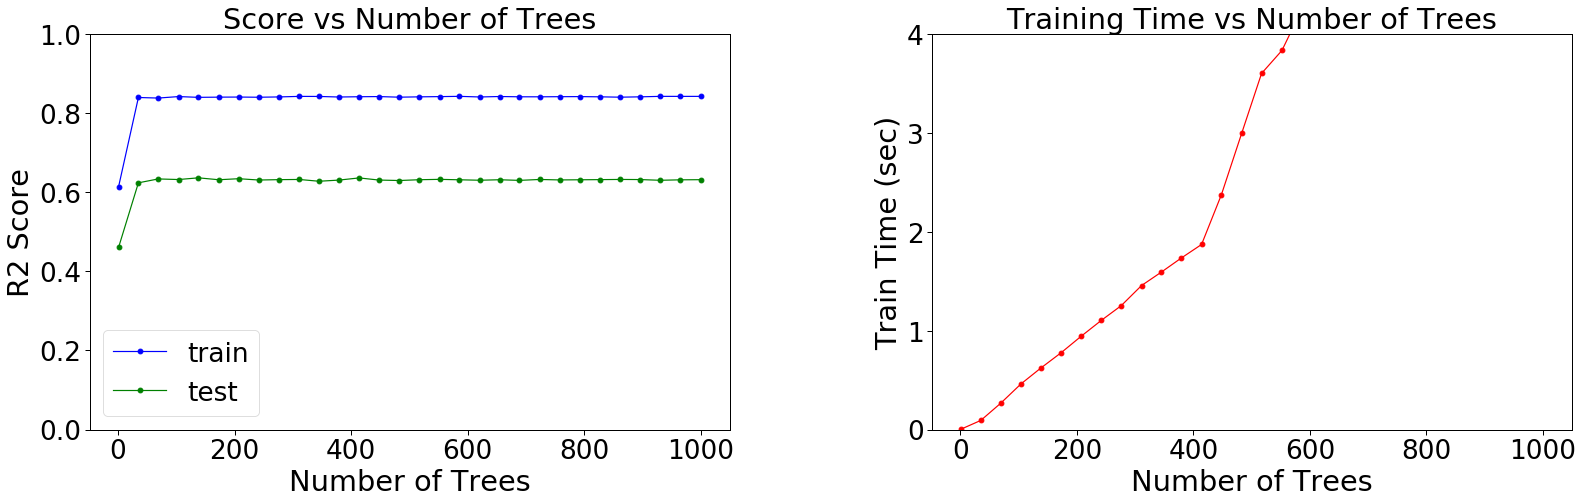

In [78]:
plot_results(tree_grid_search)

In [79]:
# Define a grid over only the maximum number of features
feature_grid = {'max_features': list(range(1, X_train.shape[1] + 1))}

In [80]:
# Create the grid search and fit on the training data
feature_grid_search = GridSearchCV(rf, param_grid=feature_grid, cv = 3, n_jobs=-1, verbose= 2,
                                  scoring = 'r2')
feature_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    4.6s remaining:    4.0s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:    4.8s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': [1, 2, 3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='r2', verbose=2)

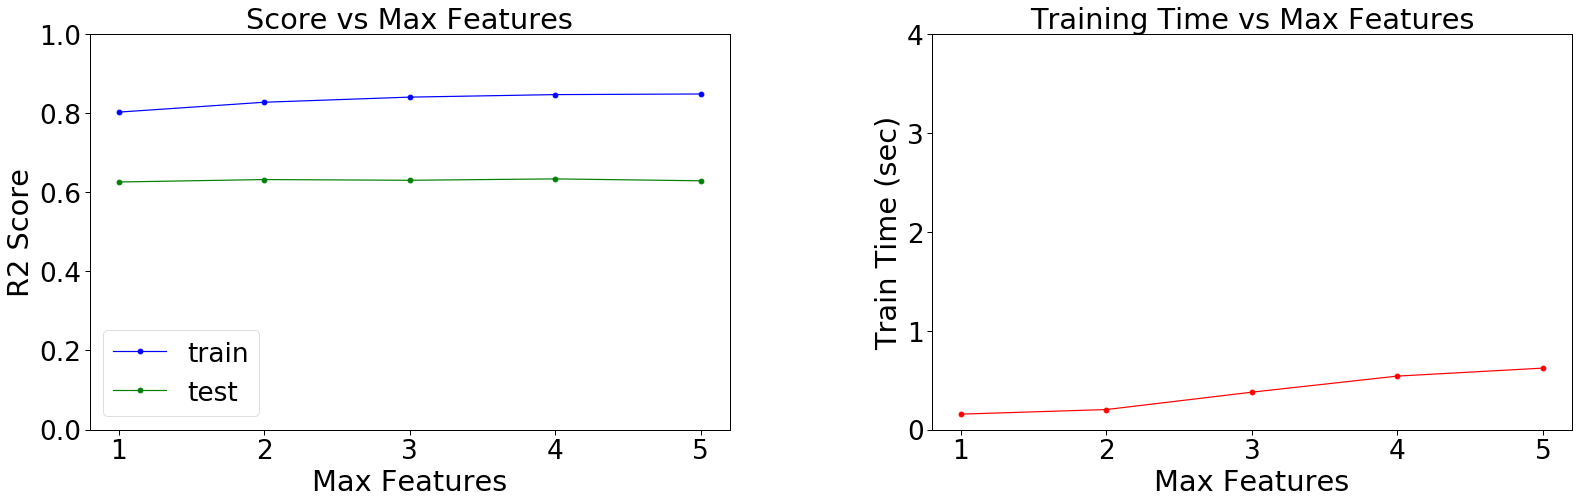

In [81]:
plot_results(feature_grid_search, param='max_features', name = 'Max Features')

In [101]:
rf = RandomForestRegressor(bootstrap = True, max_depth = 80, max_features = 3,
                           min_samples_leaf = 3, min_samples_split = 3,
                           n_estimators = 400)
rf.fit(X_train, y_train)

print(cross_val_score(rf, X_test, y_test, cv=5))
print(rf.score(X_test,y_test))

[0.64126381 0.77839638 0.65530605 0.69171404 0.76438092]
0.7697674546884085


In [98]:
# Test Data
season_2018 = pd.read_csv('2018_season.csv')
season_2018 = season_2018.drop(['blanl', 'blank2'], axis=1)
season_2018 = season_2018[season_2018.Tm.str.contains('TOT') == False]
# Maybe use this for classification?
season_2018['MVP_Candidate'] = np.where(season_2018['MVPSHARES'] > 0, 'Yes', 'No')
season_2018['Player'] = season_2018['Player'].astype(str).str.replace('*', '')
season_2018['PPG'] = season_2018['PTS'] / season_2018['G']
season_2018['ASTPG'] = season_2018['AST'] / season_2018['G']
season_2018['STLPG'] = season_2018['STL'] / season_2018['G']
season_2018['BLKPG'] = season_2018['BLK'] / season_2018['G']
season_2018['PFPG'] = season_2018['PF'] / season_2018['G']
season_2018['TRPG'] = season_2018['TRB'] / season_2018['G']
season_2018['ORPG'] = season_2018['ORB'] / season_2018['G']
season_2018['DRPG'] = season_2018['DRB'] / season_2018['G']
season_2018['MPPG'] = season_2018['MP'] / season_2018['G']

season_2018 = season_2018[season_2018['G'] >= 41.0]
season_2018 = season_2018[season_2018['MPPG'] >= 25.0]
season_2018 = season_2018.dropna()

In [99]:
test_pred = rf.predict(season_2018[feat_to_use])
test_results = pd.DataFrame(season_2018.Player)
test_results['score'] = test_pred
test_results['Year'] = season_2018['Year']
test_results['Share'] = season_2018['MVPSHARES']
test_results['MVP'] = season_2018['MVP']
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
232,James Harden,0.775316,2018,0.955,1
303,LeBron James,0.316129,2018,0.731,0
146,Stephen Curry,0.297045,2018,0.005,0
148,Anthony Davis,0.257955,2018,0.441,0
171,Kevin Durant,0.223396,2018,0.065,0


In [102]:
season_2017 = season_stats[season_stats['Year'] == 2017.0]
season_not2017 = season_stats[season_stats['Year'] != 2017.0]

X = season_not2017[feat_to_use]
y = season_not2017['MVPSHARES']
rf = RandomForestRegressor(bootstrap = True, max_depth = 80, max_features = 3,
                           min_samples_leaf = 3, min_samples_split = 3,
                           n_estimators = 400)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [103]:
test_pred = rf.predict(season_2017[feat_to_use])
test_results = pd.DataFrame(season_2017.Player)
test_results['score'] = test_pred
test_results['Year'] = season_2017['Year']
test_results['Share'] = season_2017['MVPSHARES']
test_results['MVP'] = season_2017['MVP']
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
24414,Kawhi Leonard,0.565860,2017,0.495,0
24216,Stephen Curry,0.512728,2017,0.051,0
24239,Kevin Durant,0.474456,2017,0.002,0
24306,James Harden,0.444739,2017,0.746,0
24654,Russell Westbrook,0.333496,2017,0.879,1


In [104]:
season_2016 = season_stats[season_stats['Year'] == 2016.0]
season_not2016 = season_stats[season_stats['Year'] != 2016.0]

X = season_not2016[feat_to_use]
y = season_not2016['MVPSHARES']
rf = RandomForestRegressor(bootstrap = True, max_depth = 80, max_features = 3,
                           min_samples_leaf = 3, min_samples_split = 3,
                           n_estimators = 400)
rf.fit(X,y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=80,
           max_features=3, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           n_estimators=400, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [105]:
test_pred = rf.predict(season_2016[feat_to_use])
test_results = pd.DataFrame(season_2016.Player)
test_results['score'] = test_pred
test_results['Year'] = season_2016['Year']
test_results['Share'] = season_2016['MVPSHARES']
test_results['MVP'] = season_2016['MVP']
test_results.sort_values('score', ascending=False).head()

,Player,score,Year,Share,MVP
23633,Stephen Curry,0.928831,2016,1.000,1
23839,Kawhi Leonard,0.504936,2016,0.484,0
23781,LeBron James,0.456614,2016,0.482,0
24070,Russell Westbrook,0.378227,2016,0.371,0
23654,Kevin Durant,0.336302,2016,0.112,0
